### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## MNIST

In [3]:
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.mnist.load_data()
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train_val = np.pad(X_train_val, ((0,0),(18,18),(18,18)), 'constant')
X_test = np.pad(X_test, ((0,0),(18,18),(18,18)), 'constant')

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=len(X_test), random_state=seed, stratify=y_train_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((50000, 64, 64), (50000,), (10000, 64, 64), (10000,))

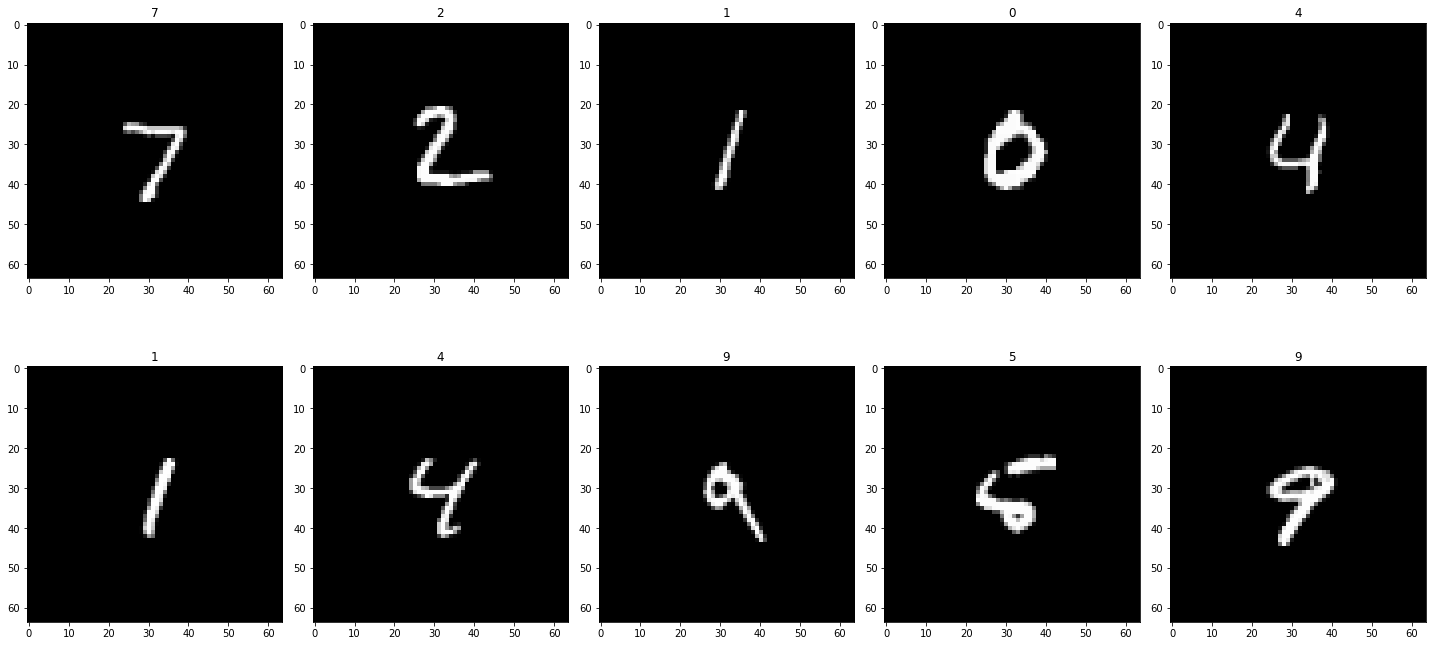

In [6]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.set_title('{}'.format(y_test[i]))
plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create the class object
datagen = ImageDataGenerator(fill_mode='constant')

# fit the generator
datagen.fit(X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_test_flip = datagen.apply_transform(X_test, transform_parameters={'ty':15})

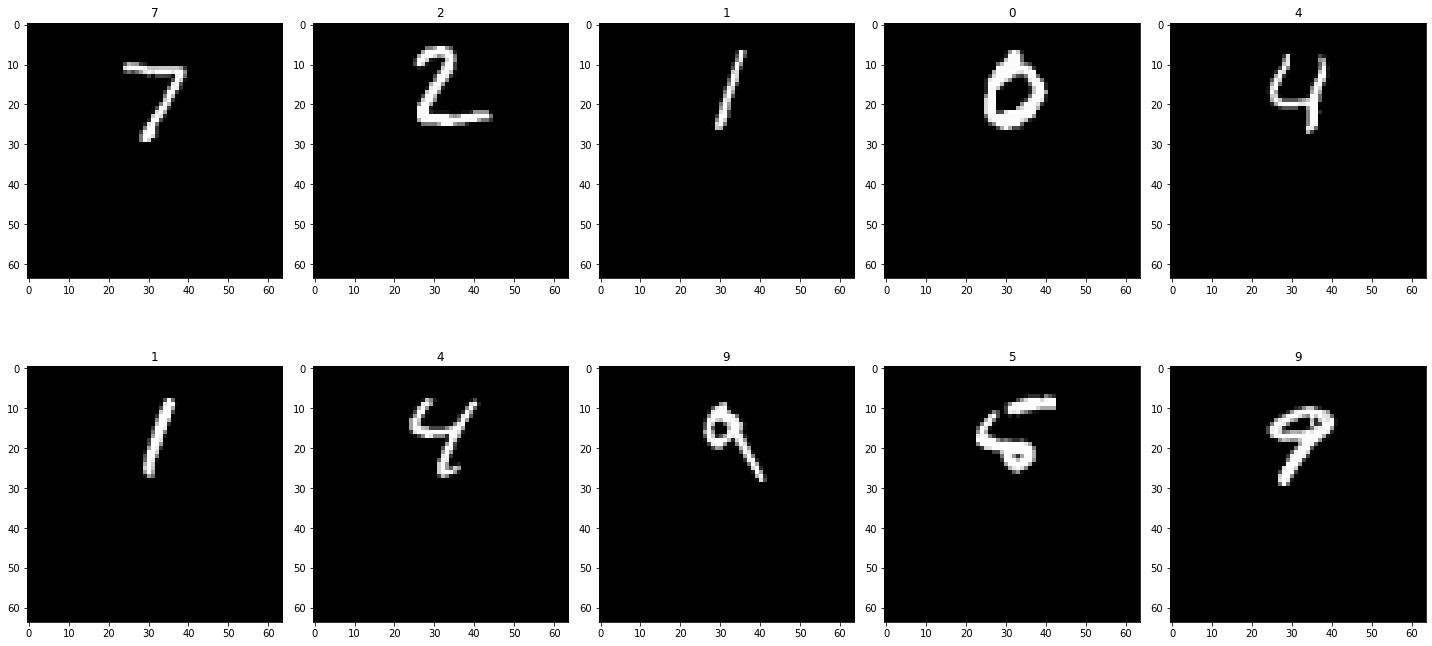

In [8]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_test_flip[i], cmap='gray')
    ax.set_title('{}'.format(y_test[i]))
plt.tight_layout()
plt.show()

### Process Data

In [9]:
# Normalize data
X_train = X_train/255.
X_val = X_val/255.
X_test = X_test/255.
X_test_flip = X_test_flip/255.

In [10]:
# Categorize labels
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

### Model metadata

In [11]:
input_shape = X_train.shape[1:]
batch_size = 128
epochs = 100

### Traditional CNN with Flattening

In [12]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    reshape = tfkl.Reshape((64,64,1))(input_layer)

    conv1 = tfkl.Conv2D(
        filters = 32,
        kernel_size = (3,3),
        activation = 'relu',
        name = 'conv1'
    )(reshape)
    pool1 = tfkl.MaxPooling2D(name='pool1')(conv1)

    conv2 = tfkl.Conv2D(
        filters = 64,
        kernel_size = (3,3),
        activation = 'relu',
        name = 'conv2'
    )(pool1)
    pool2 = tfkl.MaxPooling2D(name='pool2')(conv2)

    conv3 = tfkl.Conv2D(
        filters = 128,
        kernel_size = (3,3),
        activation = 'relu',
        name = 'conv3'
    )(pool2)
    pool3 = tfkl.MaxPooling2D(name='pool3')(conv3)

    flatten = tfkl.Flatten(name='flatten')(pool3)
    filters_dropout = tfkl.Dropout(.3, seed=seed, name='dropout1')(flatten)
    classifier = tfkl.Dense(
        64, 
        activation='relu', 
        name='classifier'
    )(filters_dropout)
    classifier_dropout = tfkl.Dropout(.3, seed=seed, name='dropout2')(classifier)
    output_layer = tfkl.Dense(
        10, 
        activation='softmax', 
        name='Output'
    )(classifier_dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64)]          0         
                                                                 
 reshape (Reshape)           (None, 64, 64, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 62, 62, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 31, 31, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 14, 14, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 128)       73856 

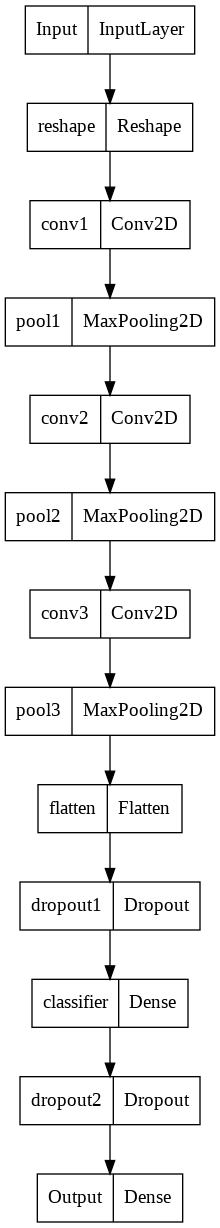

In [13]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [14]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val,y_val),
    callbacks = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
).history

Epoch 1/100
391/391 [==============================] - 43s 34ms/step - loss: 0.3382 - accuracy: 0.8922 - val_loss: 0.0763 - val_accuracy: 0.9774
Epoch 2/100
391/391 [==============================] - 13s 32ms/step - loss: 0.0978 - accuracy: 0.9709 - val_loss: 0.0532 - val_accuracy: 0.9855
Epoch 3/100
391/391 [==============================] - 13s 32ms/step - loss: 0.0691 - accuracy: 0.9795 - val_loss: 0.0467 - val_accuracy: 0.9875
Epoch 4/100
391/391 [==============================] - 13s 34ms/step - loss: 0.0573 - accuracy: 0.9833 - val_loss: 0.0475 - val_accuracy: 0.9881
Epoch 5/100
391/391 [==============================] - 13s 33ms/step - loss: 0.0468 - accuracy: 0.9856 - val_loss: 0.0492 - val_accuracy: 0.9868
Epoch 6/100
391/391 [==============================] - 13s 33ms/step - loss: 0.0394 - accuracy: 0.9881 - val_loss: 0.0356 - val_accuracy: 0.9896
Epoch 7/100
391/391 [==============================] - 13s 32ms/step - loss: 0.0403 - accuracy: 0.9878 - val_loss: 0.0404 - val_ac

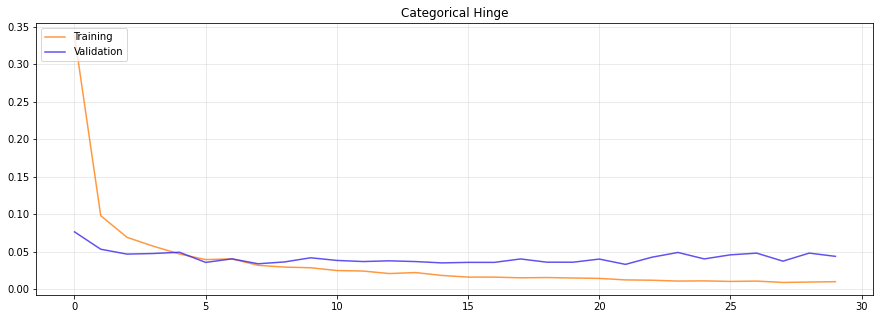

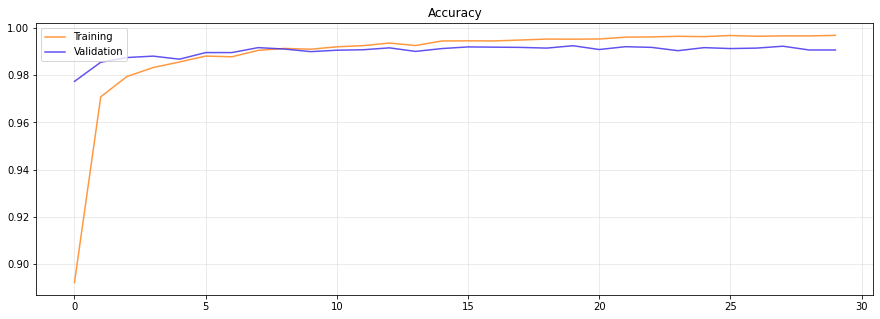

In [15]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#3A27ED')
plt.legend(loc='upper left')
plt.title('Categorical Hinge')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#3A27ED')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Accuracy: 0.9937
Precision: 0.9937
Recall: 0.9935
F1: 0.9936


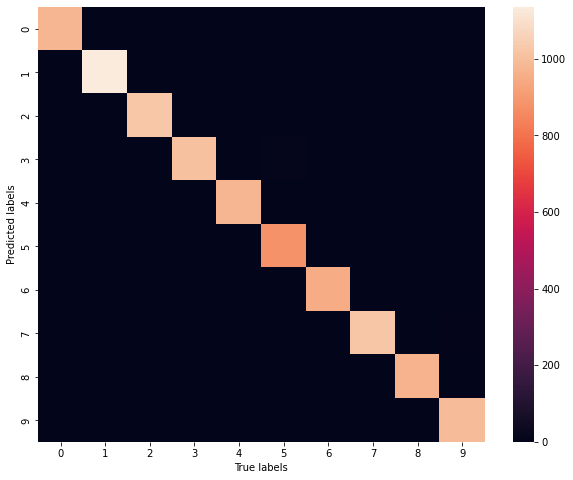

In [16]:
predictions = model.predict(X_test)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy: 0.067
Precision: 0.0312
Recall: 0.0696
F1: 0.0317


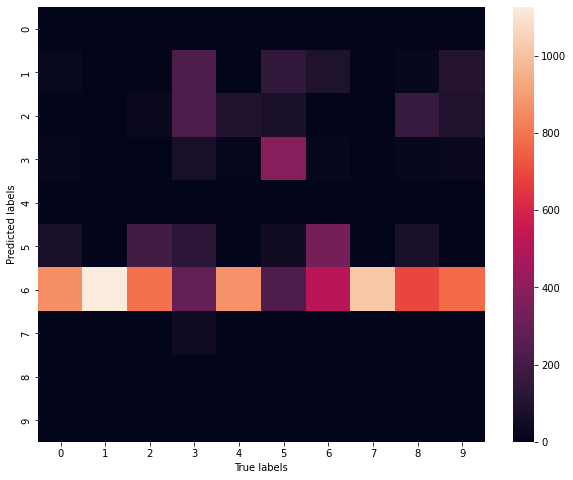

In [17]:
predictions = model.predict(X_test_flip)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### GAP CNN

In [18]:
def build_gap_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    reshape = tfkl.Reshape((64,64,1))(input_layer)

    conv1 = tfkl.Conv2D(
        filters = 32,
        kernel_size = (3,3),
        activation = 'relu',
        name = 'conv1'
    )(reshape)
    pool1 = tfkl.MaxPooling2D(name='pool1')(conv1)

    conv2 = tfkl.Conv2D(
        filters = 64,
        kernel_size = (3,3),
        activation = 'relu',
        name = 'conv2'
    )(pool1)
    pool2 = tfkl.MaxPooling2D(name='pool2')(conv2)

    conv3 = tfkl.Conv2D(
        filters = 128,
        kernel_size = (3,3),
        activation = 'relu',
        name = 'conv3'
    )(pool2)
    gpool = tfkl.GlobalAveragePooling2D(name='gpooling')(conv3)

    
    filters_dropout = tfkl.Dropout(.3, seed=seed, name='dropout1')(gpool)
    classifier = tfkl.Dense(
        64, 
        activation='relu', 
        name='classifier'
    )(filters_dropout)
    classifier_dropout = tfkl.Dropout(.3, seed=seed, name='dropout2')(classifier)
    output_layer = tfkl.Dense(
        10, 
        activation='softmax', 
        name='Output'
    )(classifier_dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64)]          0         
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 62, 62, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 31, 31, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 14, 14, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 128)       73856 

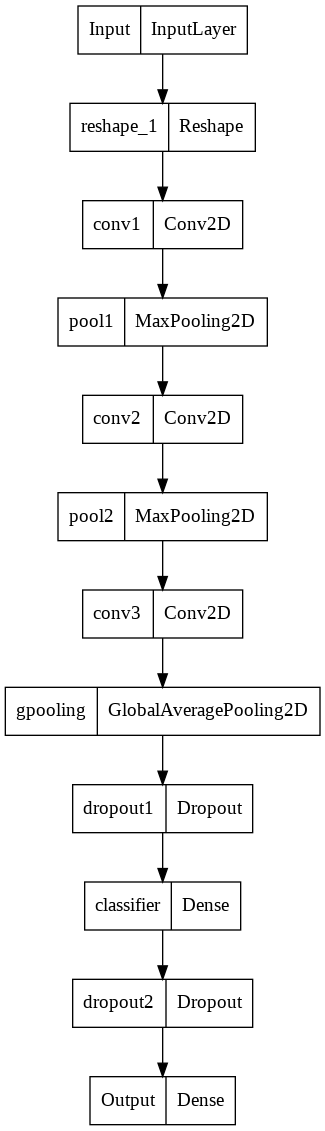

In [19]:
gap_model = build_gap_model(input_shape)
gap_model.summary()
tfk.utils.plot_model(gap_model)

In [20]:
history = gap_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val,y_val),
    callbacks = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
).history

Epoch 1/100
391/391 [==============================] - 14s 34ms/step - loss: 1.4024 - accuracy: 0.4763 - val_loss: 0.5526 - val_accuracy: 0.8543
Epoch 2/100
391/391 [==============================] - 13s 33ms/step - loss: 0.5323 - accuracy: 0.8267 - val_loss: 0.2531 - val_accuracy: 0.9244
Epoch 3/100
391/391 [==============================] - 12s 32ms/step - loss: 0.3294 - accuracy: 0.8995 - val_loss: 0.1757 - val_accuracy: 0.9470
Epoch 4/100
391/391 [==============================] - 12s 32ms/step - loss: 0.2577 - accuracy: 0.9224 - val_loss: 0.1373 - val_accuracy: 0.9600
Epoch 5/100
391/391 [==============================] - 12s 32ms/step - loss: 0.2221 - accuracy: 0.9345 - val_loss: 0.1167 - val_accuracy: 0.9647
Epoch 6/100
391/391 [==============================] - 12s 32ms/step - loss: 0.1870 - accuracy: 0.9441 - val_loss: 0.1073 - val_accuracy: 0.9672
Epoch 7/100
391/391 [==============================] - 12s 32ms/step - loss: 0.1641 - accuracy: 0.9514 - val_loss: 0.1087 - val_ac

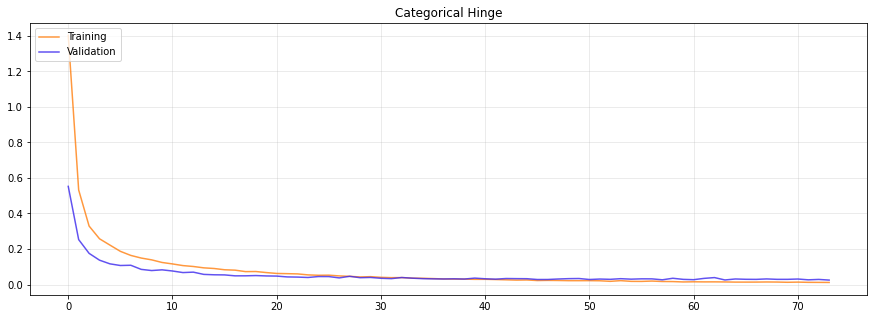

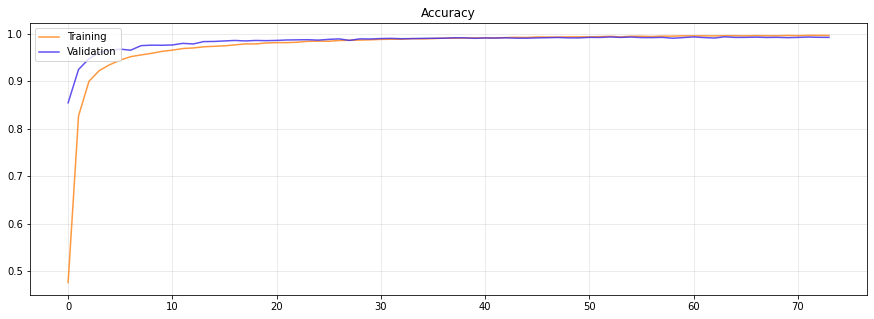

In [21]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#3A27ED')
plt.legend(loc='upper left')
plt.title('Categorical Hinge')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#3A27ED')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Accuracy: 0.993
Precision: 0.9931
Recall: 0.9929
F1: 0.993


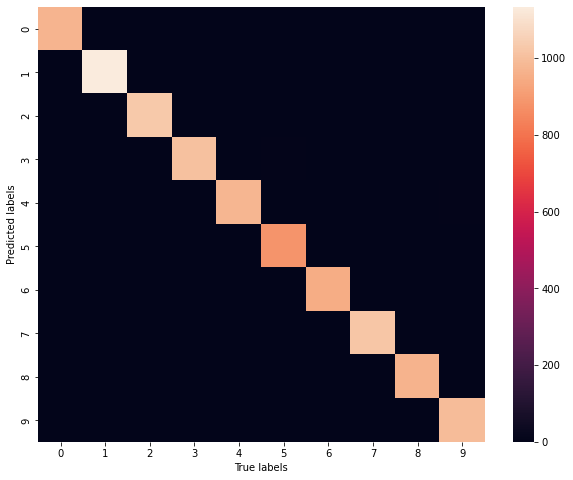

In [22]:
predictions = gap_model.predict(X_test)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy: 0.9926
Precision: 0.9926
Recall: 0.9925
F1: 0.9925


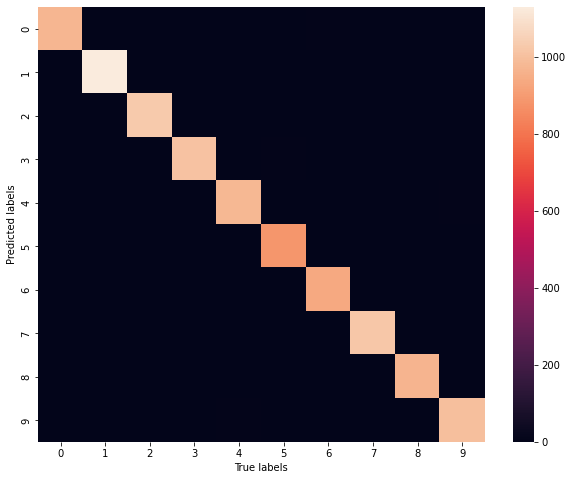

In [23]:
predictions = gap_model.predict(X_test_flip)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()